# Introduction

This project will address the implementation of a neural network to learn the Q-table for a grid world problem. The grid world problem is defined as follows:

Given an agent that starts in a specified state, this agent's goal is to reach the goal state. The goal state has reward 1, all other non-terminal states have reward 0. At each state, an agent has four actions: North, South, East, and West. For our problem, these actions will be deterministic. If an agent takes an action, the action will move the agent to the corresponding state. If an action will move an agent out of the grid, the agent will remain in the same position.

It is possible to create walls and/or other terminal states with different positive/negative rewards. However, our main focus will be on using an actor-critic architecture to approximate the Q-value function in a custom grid world problem. 

We will use a 5x5 grid world where the starting state is (0, 0) and the end state is (4, 4).

# Algorithm

In an actor-critic (ADP) structure, there are two networks: an actor network and a critic network. The critic network attempts to reduce the error function $e_{c}(t)$, defined as follows:

$$e_{c}(t)=\alpha Q(t)-[Q(t-1)-r(t)]$$

The Q-value function is represented by $Q(t)$, usually notated as $J$ in cases that do not involve Q-learning. Repeated passes of state-action pairs through the critic network will tune its parameters and reduce $e_{c}(t)$ over time.

The actor network drives the agent system towards $U_{c}$, the optimal objective of the Q-value function by reducing $e_{a}(t)$ as follows:

$$e_{a}(t)=J(t)-U_{c}(t)$$

When combined, these two neural networks can be used together to approximate the optimal Q-value of each state.

## Psuedocode

The simplest implementation of an actor-critic architecture involves creating two multi-layer perceptron networks that use stochastic gradent descent (SGD) as an optimizer. In Figure 1 we define the weight updating rules for both networks:

In [1]:
#imports

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K

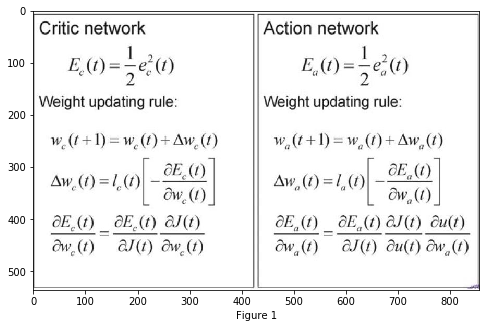

In [2]:
img = cv2.imread('ADP weight updating rules.jpg')
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.xlabel('Figure 1')
plt.show()

We can see from Figure 1 that SGD uses a variant of mean squared error as an objective function. We show psuedocode for SGD in Figure 2:

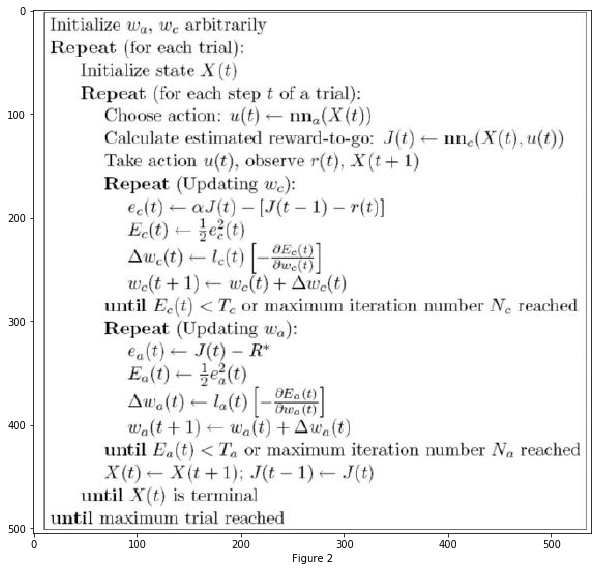

In [3]:
img = cv2.imread('SGD psuedocode.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.xlabel('Figure 2')
plt.show()

SGD represents the forward pass of the input throuth the neural network. We also have backpropagation afterward to update the network weights, shown in Figure 3:

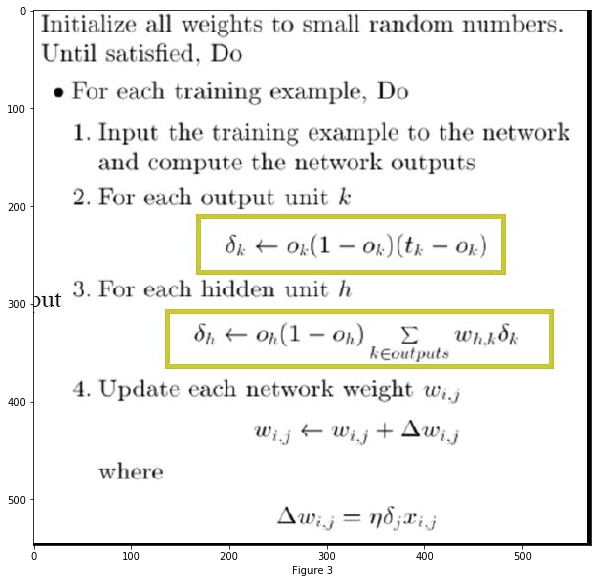

In [4]:
img = cv2.imread('Backpropagation psuedocode.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.xlabel('Figure 3')
plt.show()

## Implementation and Parameters

The rest of our implementation steps are shown below:

In [5]:
#define Agent class which will build actor and critic networks

class Agent(object):
    def __init__(self, alpha, beta, gamma=0.9, n_actions=4,
                layer1_size=2, layer2_size=1, input_dims=2):
        self.alpha=alpha #actor network learning rate
        self.beta=beta #critic network learning rate
        self.gamma=gamma #discount factor
        self.n_actions=n_actions #number of actions
        self.fc1_dims=layer1_size #number of nodes in first hidden layer
        self.fc2_dims=layer2_size #number of nodes in second hidden layer
        self.input_dims=input_dims #dimensionality of state space
        
        self.actor, self.critic, self.policy=self.build_actor_critic_network() #build actor and critic networks
        self.action_space=[i for i in range(self.n_actions)] #build action space
        
    def build_actor_critic_network(self):
        '''This function builds an actor, critic, and policy network using the Keras library.'''
        net_input=Input(shape=(self.input_dims,))       
        dense1=Dense(units=self.fc1_dims, activation='relu')(net_input)
        dense2=Dense(units=self.fc2_dims, activation='relu')(dense1)
        probs=Dense(units=self.n_actions, activation='softmax')(dense2)
        values=Dense(units=1, activation='linear')(dense2)        
                
        actor=Model(inputs=[net_input], outputs=[probs]) #actor network takes in state and outputs probability distribution 
                                                         #for each action        
        
        actor.compile(optimizer=Adam(lr=self.alpha), loss='mse') #mse= mean squared error
        
        critic=Model(inputs=[net_input], outputs=[values]) #critic network takes in state and outputs reward-to-go
                        
        critic.compile(optimizer=Adam(lr=self.beta), loss='mse')
        
        policy=Model(inputs=[net_input], outputs=[probs]) #policy network is not trained or optimized, but helps the actor 
                                                       #network make decisions               
        
        return actor, critic, policy     
    
    def choose_action(self, observation):
        '''This function uses the actor network to select an action based on the current predicted policy'''
        state=observation[np.newaxis, :]
        probabilities=self.policy.predict(state)[0] #update probability distribtuion for actions        
        action=np.random.choice(self.action_space, p=probabilities) #select action
        
        return action
    
    def learn(self, state, action, reward, state_, done):
        '''This function updates the weights of the actor and critic network based on an observation from the environment'''
        state=state[np.newaxis, :] #current state
        state_=state_[np.newaxis, :] #next state
        
        critic_value_=self.critic.predict(state_) #next utility value
        critic_value=self.critic.predict(state) #current utility value
                
        target=reward+self.gamma*critic_value_*(1-int(done)) #true utility value        
        
        actions=np.zeros((1, self.n_actions))
        actions[np.arange(1), action]=1.0
        
        self.actor.fit(state, actions, verbose=0) #train actor network
        self.critic.fit(state, target, verbose=0) #train critic network
        
    def step(self, state, action, reward, done):
        '''This function transitions the agent from one state to another'''
        if self.action_space[action]==0: # move north
            if state[1]<4:
                state[1] +=1            
        elif self.action_space[action]==1: # move south
            if state[1]>0:
                state[1]-=1            
        elif self.action_space[action]==2: # move east
            if state[0]<4:
                state[0]+=1
        elif self.action_space[action]==3: #move west
            if state[0]>0:
                state[0]-=1
        if state[0]==4 and state[1]==4: #check if at terminal state
            done=True
        
        return state, reward, done   

With the Agent class created, we discuss our parameters. There are three networks defined in the Agent class: the actor, critic, and policy networks. 

The actor network is a multi-layer neural network that takes as input the current state, and outputs a probability distibution of the four different agents the agent can take. Action '0' corresponds to "North", Action '1' corresponds to "South", Action '2' corresponds to "East", and Action '3' corresponds to "West". It has two fully connected hidden layers, for which we will vary the number of nodes for experimental purposes. Each of the fully connected layers uses Rectified Linear Unit, or ReLU. The critic and policy networks share these layers as well. The output layer for the actor network has four nodes, corresponding to each action in the action space. It has a softmax activation function, so that it can output a probability distribution of each action for the agent to take. It will use Adam as an optimizer, which is an adaptive version of stochastic gradient descent supported by recent RL research.

The critic network takes the same state input as the actor network, and is aware of the actions taken at each step when transitioning between states and updating the weights. It shares the same two fully connected layers as the actor network. This was done for the purposes of simplifying implementation. The critic network outputs a predicted reward-to-go, or utility value, known as Q in Q-learning. It will also use Adam as an optimizer.

The policy network is never compiled or used for training or weight updating. It shares the smae architecture as the actor and critic networks. It mainly exists to help the actor network keep track of its current plan to reach the goal state, as it outputs a similar probability distribution to the actor network.

We note here that much of this Agent class framework was taken from the following Youtube tutorial, found here: 

https://www.youtube.com/watch?v=2vJtbAha3To

The author here implements actor critic methods to solve the Lunar Lander game in OpenAI gym. The following changes were necessary to adapt the tutorial here to the gridworld problem:

1. The state space for Lunar Lander is 8-dimensional, whereas the state space for Lunar Lander is 2-dimensional.
2. The OpenAI gym library for Reinforcement Learining has a custom step function made for each of its environments. Since the gridworld environment is not contained within the OpenAI gym library, it was impossible to use this. Thus, a custom step function was created in the Agent class above, which performs the transition between states.
3. The author shows users how to create a custom loss function in Keras. This was unnecessary for our problem, and a loss function of mean squared error was used for both the actor and critic networks.
4. We will conduct different experiments with varying layer sizes, as it is probable that a network as big as the one used in the lunar lander problem is not necessary for the gridworld problem.

The Agent class is initialized with a default discount factor $\gamma$ of 0.9. Due to computational complexity of neural network methods, it is diffcult to execute multiple iterations of the gridworld experiment, each with many episodes. Thus, we will play with our network parameters, running each experiment for 50 episodes. As a performance measure, we will keep track of the number of steps it takes for the agent to reach the goal state in an episode. An optimal path in a 5x5 gridworld has 8 steps.

In [6]:
rewards=np.zeros((5, 5))
rewards[4][4]=1

num_episodes=50

step_average_collection=[]
for i in range(6, 11):
    print(i)
    agent=Agent(alpha=0.00001, beta=0.00005, layer1_size=2**i, layer2_size=2**(i-1))
    steps_per_episode=[]
    step_averages=[]
    for j in range(num_episodes):
        done=False
        count=0
        observation=np.array((0, 0))
        while not done:        
            action=agent.choose_action(observation) #select action        
            observation_, reward, done=agent.step(observation, action, rewards[observation[0]][observation[1]], done)
                                                                            #transition to next state
            agent.learn(observation, action, reward, observation_, done) #update network weights
            observation=observation_ #update state
            count +=1 #update step counter

        steps_per_episode.append(count)
        avg_steps_per_episode=np.mean(steps_per_episode)    
        step_averages.append(avg_steps_per_episode)    

6
7


KeyboardInterrupt: 

# Results

Running experiments with the parameters defined above produces the results below:

In [ ]:
plt.plot(step_average_collection[0], label='layer1=64, layer2=32')
plt.plot(step_average_collection[1], label='layer1=128, layer2=64')
plt.plot(step_average_collection[2], label='layer1=256, layer2=128')
plt.plot(step_average_collection[3], label='layer1=512, layer2=256')
plt.plot(step_average_collection[4], label='layer1=1024, layer2=512')
plt.xlabel('Episode')
plt.ylabel('Average number of steps')
plt.legend()
plt.show()

From the plot above, we can see that the networks with larger hidden layers converge to an optimal policy most efficiently. In particular, it appears the network configuration with 512 nodes in layer 1 and 256 nodes in layer 2 had a few outliers in terms of the number of steps in the episode due to the randomness in the porbability distributions. The network configuration with 1024 nodes in layer 1 and 512 nodes in layer 2, by contrast, started out high and then converged to about the same number of optimal steps as its previous configuration. We now compare this step-to-go curve with the one with reliable results obtained from Project 2 in Figure 4:

In [ ]:
img = cv2.imread('P2 step-to-go.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.xlabel('Figure 4')
plt.show()

Comparing this with the plot above, we see that the single and double Q-learning variants also started out with a high number of steps to reach the goal initially but they both eventually found the optimal policy of 8 steps, the single variant reching this policy faster that the double variant. It does not appear that the neural network variant found this optimal policy, instead converging to an average of around 30-40 steps per episode. Perhaps this could change with more training, but due to lack of computational resources and time constraints, we were only able to run 50 episodes per experiment.

Because the learning rates for the neural networks used are quite small, it would not be a fair comparison to compare the Q-tables between this project and Project 2. In addition, since the critic network only predicts one utility value at a time, it is not always straightforward to construct a Q-table based on states and actions from these predictions. So, we omit these here.

# Conclusions

From the neural network experiments in this report, we can draw the following conclusions:

1. The first experiment, where the first fully connected layer has 64 nodes and the second fully connected layer has 32, converged to an optimal policy of around 150-200 steps towards the goal.

2. The second experiment, where the first fully connected layer has 128 nodes and the second fully connected layer has 64, converged to an optimal policy of around 200-250 steps towards the goal.

3. The third experiment, where the first fully connected layer has 256 nodes and the second fully connected layer has 128, converged to an optimal policy of around 150-200 steps towards the goal.

4. The fourth experiment, where the first fully connected layer has 512 nodes and the second fully connected layer has 256, converged to an optimal policy of around 40-50 steps towards the goal.

5. The fifth experiment, where the first fully connected layer has 1024 nodes and the second fully connected layer has 512, converged to an optimal policy of around 40-50 steps towards the goal.

It is clear from these results that the larger networks can create a more efficient solution to the problem than the smaller ones. It is also clear that these results are inferior to that of regular Q-learning. Perhaps thy will be comparable if the networks are trained more, or perhaps there is an unwanted result coming from the implementation. Future work may seek to address these possibilities.

# References

[1] Patacchiola, Massimiliano. _Dissecting Reinforcement Learning, part 8- Multi-layer perceptron._ Dec 28, 2018. https://mpatacchiola.github.io/blog/2018/12/28/dissecting-reinforcement-learning-8.html

[2] Patacchiola, Massimiliano. _Dissecting Reinforcement Learning, part 4- Actor-critic methods._ Feb 11, 2017. https://mpatacchiola.github.io/blog/2017/02/11/dissecting-reinforcement-learning-4.html

[3] Brownlee, Jason. _How To Build Multi-Layer Perceptron Neural Network Models with Keras._ August 19, 2019. https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/

[4] Tabor, Phil. _Actor-Critic Methods are Easy with Keras._ August 29, 2019. https://www.youtube.com/watch?v=2vJtbAha3To

[5] Ni, Zhen. _Neural Networks Implementation for Adaptive Dynamic Programming_. Lecture Notes, 2020.